Compare Age
---

Age comparison plot similar to Gross et al 2019.

In [42]:
import xarray as xr
import pandas as pd
from stompy import utils
import stompy.plot.cmap as scmap
from stompy.grid import multi_ugrid
from stompy.spatial import proj_utils
import numpy as np
import os
import matplotlib.pyplot as plt
turbo=scmap.load_gradient('turbo.cpt')
%matplotlib notebook

In [29]:
# Load USGS data
data_dir="../data/usgs/20141001"

age_fn=os.path.join(data_dir,"Water_residence_time_data.xlsx")
age_df=pd.read_excel(age_fn).rename({'Timestamp':'time',
                                     'τ (days)':'tau_days',},axis=1)
age_df=age_df[ ~age_df['time'].isnull() ]

In [30]:
ll=age_df[ ['Longitude','Latitude'] ].values
xy=proj_utils.mapper('WGS84','EPSG:26910')(ll)
age_df['x']=xy[:,0]
age_df['y']=xy[:,1]

In [34]:
age_df.head(2)

,time,Latitude,Longitude,Boat Distance (mi),Boat Speed (mi/hr),WS fDOM (QSE),WS fCHLA (µg/L),C Tr (%),C 650 (m-1),NO3 (mg/L),...,EXO fCHLA (µg/L),EXO fBGAPC (µg/L),δ2H (per mil),δ18O (per mil),E/I,E/I 1σ,tau_days,τ 1σ,x,y
0,2014-10-01 10:34:34,38.2466,-121.68741,0.00605,19.37024,10.36,3.33,57.454295,40.509703,0.65,...,2.12,0.44,-75.94,-10.13,0.04905,0.000289,8.564911,2.214090,614857.294620,4.233991e+06
1,2014-10-01 10:35:05,38.2490,-121.68730,0.00608,19.46432,10.53,3.32,57.769041,40.564521,0.65,...,2.03,0.44,-75.90,-10.09,0.04970,0.000288,8.911129,2.243596,614863.142625,4.234257e+06


<IPython.core.display.Javascript object>


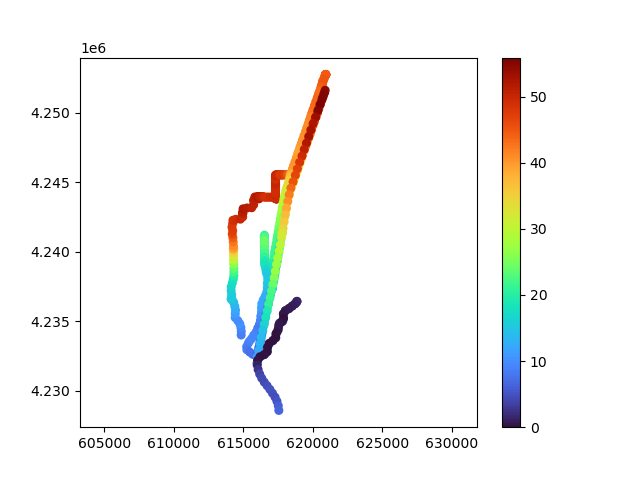

In [36]:
plt.figure()
scat=plt.scatter(age_df.x, age_df.y, 30,age_df.tau_days,cmap=turbo)
plt.axis('equal')
plt.colorbar(scat)

In [44]:
# Get map output around the time of the cruise
run_dirs=['/opt2/csc/dflowfm/runs/age2014_v01']

import six
six.moves.reload_module(multi_ugrid)

mus=[ multi_ugrid.MultiUgrid(os.path.join(d,'DFM_OUTPUT_flowfm','flowfm_*_map.nc'))
      for d in run_dirs]

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

<IPython.core.display.Javascript object>


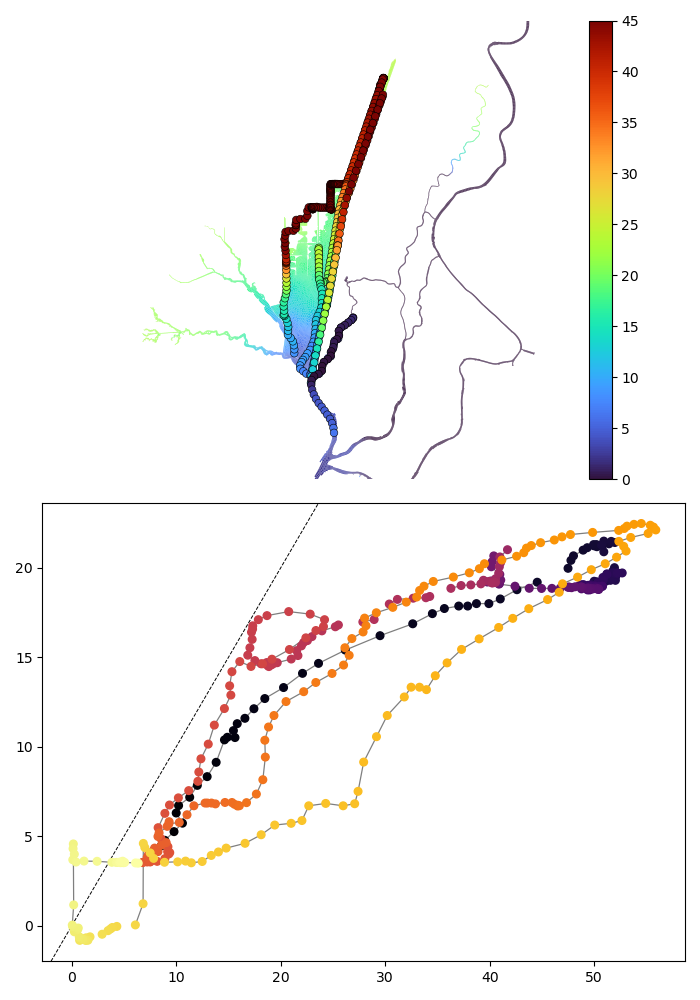

Map time error: 1.42 to -2.45 hours


In [96]:
# both the run and the data should be in PST
fig,axss=plt.subplots(2,len(mus),squeeze=False,figsize=(7,10))
axs=axss[0,:]
axscats=axss[1,:]

clim=[0,45]

for ax,axscat,mu in zip(axs,axscats,mus):
    scat=ax.scatter(age_df.x, age_df.y, 30,age_df.tau_days,cmap=turbo,zorder=2,
                   ec='k',lw=0.4)
    t_cruise=age_df['time'].values  
    tidx=np.searchsorted(mu.time.values,t_cruise[0])
    t_map=mu.time.values[tidx]
    t_err_hours=(t_map-t_cruise)/np.timedelta64(1,'s')/3600.
    print("Map time error: %.2f to %.2f hours"%(t_err_hours[0], t_err_hours[-1]))
    mod_ageconc=mu['mesh2d_NO3'].isel(time=tidx).values
    mod_conc   =mu['mesh2d_RcNit'].isel(time=tidx).values
    mod_age=mod_ageconc/mod_conc.clip(1e-6)
    sel=mod_conc>1e-6
    mod_age[~sel]=np.nan
    
    # Match each age sample with a cell, using
    # cells_nearest to allow for samples not falling exactly within a
    # cell
    age_xy=np.c_[age_df.x,age_df.y]
    age_ref=np.argmin(age_df.tau_days)
    age_ref_xy=age_xy[age_ref]
    
    # For the age_ref, find the nearest valid cell    
    cell_ref=np.argmin( np.where(sel,
                                 utils.dist(mu.grid.cells_center() - age_ref_xy),
                                 1e6) )
    offset=mod_age[cell_ref] - age_df.tau_days[age_ref]

    # When bringing in error metrics, probably better to fit overall,
    # in case there is substantial error at the reference point
    mod_age -= offset    
    cells=mu.grid.points_to_cells(age_xy, method='cells_nearest')
    ccoll=mu.grid.plot_cells(values=mod_age,
                             mask=sel,cmap=turbo,ax=ax)
    plt.setp([ccoll,scat],clim=clim)
    ax.axis('equal')
    ax.axis('off')
    plt.colorbar(ccoll,ax=ax,orientation='vertical')
    ax.axis((599410.1696215905, 631017.7729131989, 4226915.966264306, 4255155.546254349))
    
    # And the scatter:
    axscat.plot( age_df.tau_days, mod_age[cells], lw=0.9,color='k',alpha=0.5,
                zorder=0)

    axscat.scatter( age_df.tau_days, mod_age[cells], 30, age_df.time-age_df.time.min(),
                  cmap='inferno')
    
    axscat.axline([0,0],[1,1],color='k',ls='--',lw=0.7,zorder=0)
fig.tight_layout()

In [82]:
mu.grid.cells_center()[]

array([[ 623143.7307435 , 4259695.70009428],
       [ 623144.23930844, 4259655.44513963],
       [ 623117.12252516, 4259695.10644877],
       ...,
       [ 605789.01663615, 4235364.31839462],
       [ 605768.45875913, 4235373.20174801],
       [ 605788.46414066, 4235374.29431818]])

In [94]:
ax.axline

<bound method Axes.axline of <AxesSubplot:>>